In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import visualization
import datahandler

In [2]:
# participant_code = 'merged_data_D0P7X9W6_preprocessed' 
load_state_data = False
data_path = './participant data/'
# data_path = './eye_merged/'
# trimmed_data, sections, gender, age, calmFirst = datahandler.load_participant(participant_code, data_path, load_state_data)

# trimmed_data['DrivingPerformanceMean'] = trimmed_data['DrivingPerformance'].rolling(window=10000, min_periods=1000).mean()
# print(f'calm first: {calmFirst}')
# visualization.plot_column(trimmed_data, 'ET_PupilLeft', 'VelocityX', sections=sections)

In [3]:
def get_sign_windows(data, remove_nan=None, column='DistanceToNextSpeedSign', seconds=3):    
    speed_sign_data = data[data[column] == 0]
    speed_sign_data = speed_sign_data.drop_duplicates(subset=['Timestamp'])

    #drop rows around speed signs that are too close in time
    results = []
    last_event_time = None
    for idx, row in speed_sign_data.iterrows():
        current_time = row['Timestamp']
        if last_event_time is None or current_time - last_event_time >= seconds * 1000:
            results.append(row)
            last_event_time = current_time

    speed_sign_data = pd.DataFrame(results)
    amount_unique_signs = len(speed_sign_data)

    windows = pd.DataFrame(columns=speed_sign_data.columns)

    for i in range(len(speed_sign_data)):

        timestamp = speed_sign_data.iloc[i]['Timestamp']
        start_time = timestamp - seconds / 4 * 1000
        end_time = timestamp + seconds * 1000
        
        # Select the rows within the time window
        time_window_data = data[(data['Timestamp'] >= start_time) & (data['Timestamp'] <= end_time)]
        if remove_nan:
            time_window_data = time_window_data.dropna(subset=remove_nan)
        #remove empy or full nan columns    
        time_window_data = time_window_data.dropna(axis=1, how='all')
        windows = pd.concat([windows, time_window_data], ignore_index=True)


    windows = windows.sort_values(by='Timestamp')

    return windows, amount_unique_signs

In [ ]:
# %matplotlib agg

_ = visualization.compare_perf_kdes(participant_code, get_sign_windows(trimmed_data)[0], sections=sections, save_path='./perf_plots/events_analysis/')
# %matplotlib inline

/tmp/ipykernel_46931/2548162100.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  windows = pd.concat([windows, time_window_data], ignore_index=True)


### Analyze distributions

In [41]:
import os
#surpress warnings
# import warnings
# warnings.filterwarnings("ignore")
from scipy.stats import skew


def get_all_stats(remove_outliers=None,
                  drop_gender=None,
                  drop_order=None,
                  save_folder=''):
  for root, dirs, files in os.walk(data_path):
    identifiers = [
        f.replace('.csv', '') for f in files
        if f != "W1D9N0B8.csv" and f != 'M3A2H7Q4.csv'
    ]
  print(identifiers)

  intense_stats = []
  calm_stats = []
  baseline_stats = []
  cool_down_stats = []
  total_speed_signs = 0
  total_overhead_signs = 0
  total_data = None
  for id in identifiers:
    load_state_data = False

    try:
      trimmed_data, sections, gender, age, calmFirst = datahandler.load_participant(
          id, data_path, load_state_data, remove_outliers=remove_outliers)
      print(f'{id} OK')
      calmFirst = "PN" if calmFirst else "NP"
      if gender == drop_gender:
        print(f'Skipping {id} cause of gender')
        continue
      if drop_order and calmFirst == drop_order:
        print(f'Skipping {id} cause of order')
        continue
    except Exception as e:
      print(f'{id} FAIL')
      # print(e)
      continue

    # trimmed_data['VelocityXMean'] = trimmed_data['VelocityX'].rolling(window=10000).mean()
    # trimmed_data['DistanceToTargetPositionStd'] = trimmed_data['DistanceToTargetPosition'].rolling(window=10000).std()
    # trimmed_data['DistanceToTargetSpeed_Mean'] = trimmed_data['DistanceToTargetSpeed'].rolling(window=10000).mean()
    # trimmed_data['VelocityX_Mean'] = trimmed_data['VelocityX'].rolling(window=10000).mean()
    # print(f'I got {trimmed_data['Participant'].unique()} as participant')
    windowed_data, amount_signs = get_sign_windows(trimmed_data,
                                                   remove_nan=remove_outliers,
                                                   seconds=3)
    # print(f'Now I got {windowed_data['Participant'].unique()} as participant')
    total_speed_signs += amount_signs
    windowed_data2, amount_signs = get_sign_windows(
        trimmed_data,
        remove_nan=remove_outliers,
        column='DistanceToNextOverheadSign')
    total_overhead_signs += amount_signs

    windowed_data = pd.concat([windowed_data, windowed_data2],
                              ignore_index=True)
    windowed_data = windowed_data.sort_values(by='Timestamp')

    visualization.compare_perf_kdes(id,
                                    windowed_data,
                                    sections=sections,
                                    save_path=save_folder)

    pairs = [
        ('VelocityX', 'Lateral Velocity'),
        ('DistanceToTargetSpeed', 'Difference to Correct Speed'),
        ('DistanceToTargetPosition', 'Distance to Correct Lane'),
        ('DrivingPerformance', 'Driving Performance'),
    ]

    for (col1, col2) in pairs:
      mean1, std1, mom1, mean2, std2, mom2, mean3, std3, mom3, mean4, std4, mom4 = datahandler.get_statistics(
          windowed_data, col1, col2, sections=sections)
      calm_stats.append((mean1, std1, mom1))
      intense_stats.append((mean2, std2, mom2))
      baseline_stats.append((mean3, std3, mom3))
      cool_down_stats.append((mean4, std4, mom4))
    if total_data is None:
      # print(f'Initializing {id} data')
      total_data = windowed_data.copy()
    else:
      # print(f'Concatenating {id} data')
      # print(f'total data unique: {total_data['Participant'].unique()}')
      # print(f'windowed data unique: {windowed_data['Participant'].unique()}')
      total_data = pd.concat([total_data, windowed_data], ignore_index=True)

  total_data = total_data.sort_values(by='Timestamp')
  print(
      f'Total speed signs = {total_speed_signs}, total overhead signs = {total_overhead_signs}'
  )
  return calm_stats, intense_stats, baseline_stats, cool_down_stats, total_data

In [5]:
def generate_datasets(calm_stats, intense_stats, pairs):
    N = len(pairs)      
    velocity_x_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % N == 0]
    targ_speed_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % N == 1]
    position_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % N == 2]
    speed_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % N == 3]
    velocity_x_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % N == 0]
    targ_speed_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % N == 1]
    position_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % N == 2]
    speed_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % N == 3]
    datasets = [[velocity_x_intense, velocity_x_calm],
                    [targ_speed_intense, targ_speed_calm],
                    [position_intense, position_calm],
                    [speed_intense, speed_calm]]
    return datasets


In [6]:
import scipy.stats as stats
from scipy.stats import ttest_rel
from scipy.stats import kruskal
from scipy.stats import wilcoxon

def print_statistical_tests(datasets, titles):
    for j, (intense, calm) in enumerate(datasets):
        print(f'\nT-test results for {titles[j]}, intense vs calm:')
        print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
        print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
        print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')
        print(f'\nKruskal results for {titles[j]}, intense vs calm:')
        print(f'Means: {kruskal([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
        print(f'STDs: {kruskal([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
        print(f'Mom^3s: {kruskal([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')
        print(f'\nWilcoxn results for {titles[j]}, intense vs calm:')
        print(f'Means: {wilcoxon([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
        print(f'STDs: {wilcoxon([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
        print(f'Mom^3s: {wilcoxon([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')

In [42]:
#surpress warnings
import warnings
warnings.filterwarnings("ignore")



%matplotlib agg
calm_stats, intense_stats, baseline_stats,cool_down_stats,  data = get_all_stats(save_folder='perf_plots/events_analysis_all/', remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed', 'CarSpeed'])
%matplotlib inline

['C1K4L9S8', 'D0P7X9W6', 'G2Y7J4Q1', 'G9K4W1Z0', 'I8L4N6G7', 'J4X1T0D2', 'J6W7Q4H5', 'K4G7Y9O2', 'L0S1Z2I3', 'L1N3B5O2', 'M0R6U5F9', 'M4H6R2W9', 'M7D3F5K4', 'N7P5B8G0', 'O4A0U8R1', 'U6O5V2T9', 'V9L0P2K7', 'X5Q0G4J2']
C1K4L9S8 OK
D0P7X9W6 OK
G2Y7J4Q1 OK
G9K4W1Z0 OK
I8L4N6G7 OK
J4X1T0D2 OK
J6W7Q4H5 OK
K4G7Y9O2 OK
L0S1Z2I3 OK
L1N3B5O2 OK
M0R6U5F9 OK
M4H6R2W9 OK
M7D3F5K4 OK
N7P5B8G0 OK
O4A0U8R1 OK
U6O5V2T9 OK
V9L0P2K7 OK
X5Q0G4J2 OK
Total speed signs = 1065, total overhead signs = 2473


#### Compare All conditions, driving performance

In [43]:
from statannotations.Annotator import Annotator

def paired_plot_all3(data1, data2, data3, data4, title, ylabel, y='Mean', index=3):
    """This will get the driving performance data for all three conditions and plot them in a paired plot."""
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")
    # Create a DataFrame for the paired data
    order = {'Mean':0, 'Std':1, 'Mom^3':2}
    N = len(data1)
    paired_data = pd.DataFrame({
        'Condition': ['Positive']  *( len(data1) // 4 ) + ['Negative'] *(len(data2) // 4 ) + ['Baseline'] *(len(data2) // 4  ) + ['Cool Down'] *(len(data4) // 4),
        'Mean': [data1[i][0] for i in range(N) if i % 4 == index] + [data2[i][0] for i in range(N) if i % 4 == index] +
          [data3[i][0] for i in range(N) if i % 4 == index] + [data4[i][0] for i in range(N) if i % 4 == index],
        'Std': [data1[i][1] for i in range(N) if i % 4 == index] + [data2[i][1] for i in range(N) if i % 4 == index] +
          [data3[i][1] for i in range(N) if i % 4 == index] + [data4[i][1] for i in range(N) if i % 4 == index],
        'Mom^3':[data1[i][2] for i in range(N) if i % 4 == index] + [data2[i][2] for i in range(N) if i % 4 == index] + 
        [data3[i][2] for i in range(N) if i % 4 == index] + [data4[i][2] for i in range(N) if i % 4 == index]
    })
    # Create the paired plot
    sns.boxplot(x='Condition', y=y, data=paired_data, palette="Set2")
    sns.swarmplot(x='Condition', y=y, data=paired_data, color='black')

    # print(paired_data['Mean'])
    for i in range(len(data1)):
        if i % 4 == index:
            plt.plot(['Positive', 'Negative'], [data1[i][order[y]], data2[i][order[y]]], color='gray', alpha=0.4)
            plt.plot(['Negative', 'Baseline'], [data2[i][order[y]], data3[i][order[y]]], color='gray', alpha=0.4)
            plt.plot(['Baseline', 'Cool Down'], [data3[i][order[y]], data4[i][order[y]]], color='gray', alpha=0.4)
    plt.title(title)
    plt.ylabel(ylabel)

    test_pairs = [('Positive', 'Negative'), ('Negative', 'Baseline'), ('Positive', 'Baseline'), ('Negative', 'Cool Down'), ('Positive', 'Cool Down'), ('Baseline', 'Cool Down')]
    annotator = Annotator(plt.gca(), pairs=test_pairs, data=paired_data, x='Condition', y=y)
    annotator.configure(test='Wilcoxon', text_format='simple', loc='inside', show_test_name=False)
    annotator.apply_and_annotate()

    plt.tight_layout()
    plt.savefig(f'perf_plots/events_analysis_all/{title}.png')
    plt.xlabel('')
    plt.show()

In [9]:
stat_index = 0
metric_index = 3

calm_driving_perf_means = [calm_stats[i][stat_index] for i in range(len(calm_stats)) if i % 4 == metric_index]
intense_driving_perf_means = [intense_stats[i][stat_index] for i in range(len(intense_stats)) if i % 4 == metric_index]
baseline_driving_perf_means = [baseline_stats[i][stat_index] for i in range(len(baseline_stats)) if i % 4 == metric_index]
cool_down_perf_means = [cool_down_stats[i][stat_index] for i in range(len(cool_down_stats)) if i % 4 == metric_index]


In [10]:
print(wilcoxon(calm_driving_perf_means, baseline_driving_perf_means))
print(wilcoxon(intense_driving_perf_means, baseline_driving_perf_means))
print(wilcoxon(calm_driving_perf_means, intense_driving_perf_means))

WilcoxonResult(statistic=np.float64(53.0), pvalue=np.float64(0.16735076904296875))
WilcoxonResult(statistic=np.float64(53.0), pvalue=np.float64(0.16735076904296875))
WilcoxonResult(statistic=np.float64(78.0), pvalue=np.float64(0.7660293579101562))


Text(0.5, 1.0, 'Driving Performance Mean KDEs')

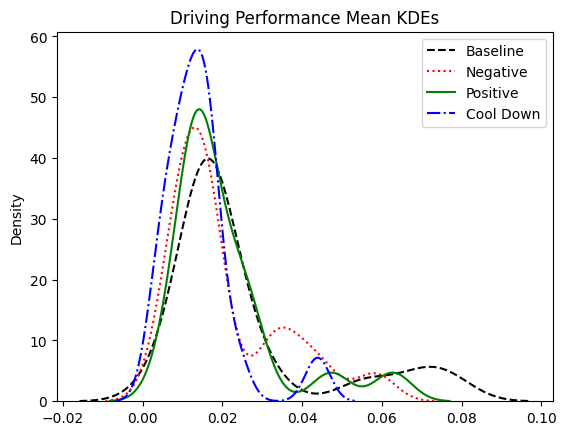

In [11]:
bw = 0.6
#kde plots with different line styles
sns.kdeplot(baseline_driving_perf_means, bw_adjust=bw, linestyle='--', color='black')
sns.kdeplot(intense_driving_perf_means, bw_adjust=bw, linestyle=':', color='red')
sns.kdeplot(calm_driving_perf_means,  bw_adjust=bw, linestyle='-', color='green')
sns.kdeplot(cool_down_perf_means,  bw_adjust=bw, linestyle='-.', color='blue')
plt.legend(['Baseline', 'Negative', 'Positive', 'Cool Down'])
plt.title('Driving Performance Mean KDEs')


Positive vs. Negative: Wilcoxon test (paired samples), P_val:1.187e-01 Stat=4.900e+01
Negative vs. Baseline: Wilcoxon test (paired samples), P_val:4.683e-01 Stat=6.800e+01
Baseline vs. Cool Down: Wilcoxon test (paired samples), P_val:4.828e-02 Stat=4.000e+01
Positive vs. Baseline: Wilcoxon test (paired samples), P_val:1.084e-01 Stat=4.800e+01
Negative vs. Cool Down: Wilcoxon test (paired samples), P_val:3.849e-02 Stat=3.800e+01
Positive vs. Cool Down: Wilcoxon test (paired samples), P_val:3.038e-01 Stat=6.100e+01


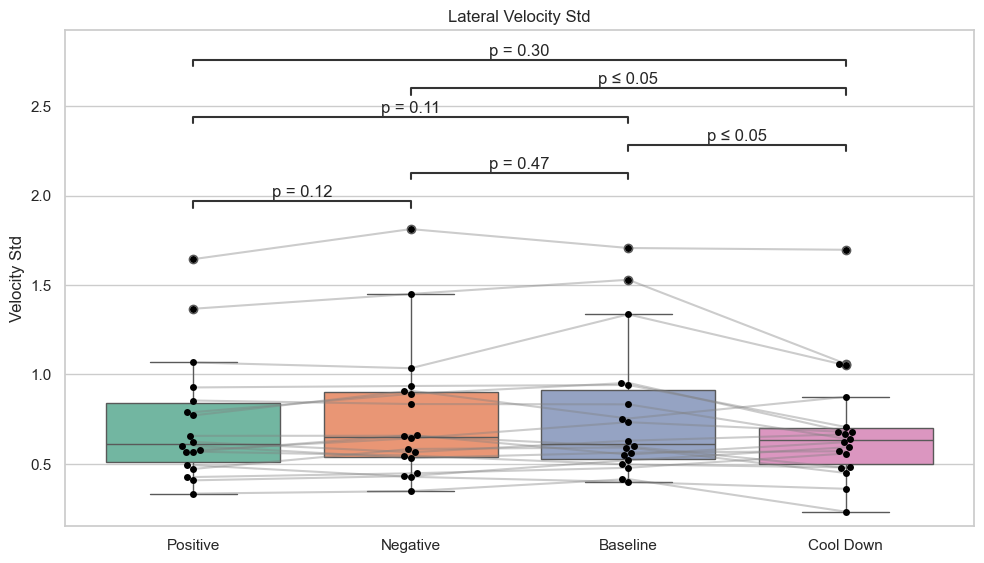

In [46]:
paired_plot_all3(calm_stats, intense_stats, baseline_stats, cool_down_stats, 'Lateral Velocity Std', 'Velocity Std', y='Std', index=0)

In [15]:
qual_data = pd.read_csv('./data/qual_groups.csv')

positive_emotionally_affected = qual_data[qual_data['P_E']]['Participant'].to_list()
positive_emotionally_not_affected = qual_data[~qual_data['P_E']]['Participant'].to_list()

negative_emotionally_affected = qual_data[qual_data['N_E']]['Participant'].to_list()
negative_emotionally_not_affected = qual_data[~qual_data['N_E']]['Participant'].to_list()

positive_influenced = qual_data[qual_data['P_I']]['Participant'].to_list()
negative_influenced = qual_data[qual_data['N_I']]['Participant'].to_list()

not_positive_influenced = qual_data[~qual_data['P_I']]['Participant'].to_list()
not_negative_influenced = qual_data[~qual_data['N_I']]['Participant'].to_list()

participant_indices = data.groupby('Participant').first().reset_index()


positive_emotionally_affected = participant_indices[participant_indices['Participant'].isin(positive_emotionally_affected)].index.to_list()
positive_emotionally_not_affected = participant_indices[participant_indices['Participant'].isin(positive_emotionally_not_affected)].index.to_list()

negative_emotionally_affected = participant_indices[participant_indices['Participant'].isin(negative_emotionally_affected)].index.to_list()
negative_emotionally_not_affected = participant_indices[participant_indices['Participant'].isin(negative_emotionally_not_affected)].index.to_list()
positive_influenced = participant_indices[participant_indices['Participant'].isin(positive_influenced)].index.to_list()
negative_influenced = participant_indices[participant_indices['Participant'].isin(negative_influenced)].index.to_list()
not_positive_influenced = participant_indices[participant_indices['Participant'].isin(not_positive_influenced)].index.to_list()
not_negative_influenced = participant_indices[participant_indices['Participant'].isin(not_negative_influenced)].index.to_list()



In [64]:
stat_index = 0
metric_index = 3

positive_affected_performance = [calm_stats[x * 4 + metric_index][stat_index] for x in positive_emotionally_affected]
negative_affected_performance = [intense_stats[x * 4 + metric_index][stat_index] for x in negative_emotionally_affected]
positive_not_affected_performance = [calm_stats[x * 4 + metric_index][stat_index] for x in positive_emotionally_not_affected]
negative_not_affected_performance = [intense_stats[x * 4 + metric_index][stat_index] for x in negative_emotionally_not_affected]
positive_influenced_performance = [calm_stats[x * 4 + metric_index][stat_index] for x in positive_influenced]
negative_influenced_performance = [intense_stats[x * 4 + metric_index][stat_index] for x in negative_influenced]
not_positive_influenced_performance = [calm_stats[x * 4 + metric_index][stat_index] for x in not_positive_influenced]
not_negative_influenced_performance = [intense_stats[x * 4 + metric_index][stat_index] for x in not_negative_influenced]

Affected vs. Not Affected: Mann-Whitney-Wilcoxon test two-sided, P_val:7.914e-01 U_stat=4.200e+01
Not Affected vs. Influenced: Mann-Whitney-Wilcoxon test two-sided, P_val:7.406e-01 U_stat=3.950e+01
Influenced vs. Not Influenced: Mann-Whitney-Wilcoxon test two-sided, P_val:6.334e-01 U_stat=4.600e+01
Affected vs. Influenced: Mann-Whitney-Wilcoxon test two-sided, P_val:9.076e-01 U_stat=2.650e+01
Not Affected vs. Not Influenced: Mann-Whitney-Wilcoxon test two-sided, P_val:9.719e-01 U_stat=5.600e+01
Affected vs. Not Influenced: Mann-Whitney-Wilcoxon test two-sided, P_val:6.598e-01 U_stat=4.000e+01


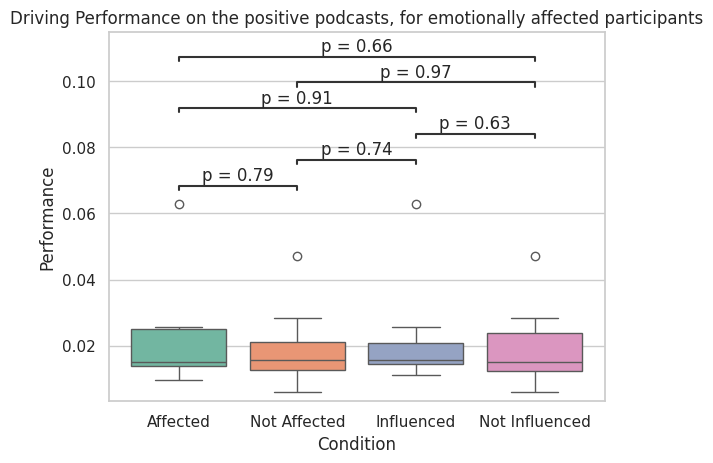

In [65]:
from itertools import combinations

positive_performance = pd.DataFrame({
  'Condition': ['Affected'] * len(positive_affected_performance) + ['Not Affected'] * len(positive_not_affected_performance) +
               ['Influenced'] * len(positive_influenced_performance) + ['Not Influenced'] * len(not_positive_influenced_performance),
  'Performance': positive_affected_performance + positive_not_affected_performance + positive_influenced_performance + not_positive_influenced_performance
})

#x = condition, y = performance
sns.boxplot(x='Condition', y='Performance', data=positive_performance, palette="Set2")
plt.title('Driving Performance on the positive podcasts, for emotionally affected participants')


#annotate the plot with statistical tests
conditions = [ 'Affected', 'Not Affected', 'Influenced', 'Not Influenced']

annotator = Annotator(plt.gca(),
                      pairs=list(combinations(conditions, 2)),
                      data=positive_performance,
                      x='Condition',
                      y='Performance')
annotator.configure(test='Mann-Whitney', text_format='simple', loc='inside', show_test_name=False)
annotator.apply_and_annotate()
plt.show()


Affected vs. Not Affected: Mann-Whitney-Wilcoxon test two-sided, P_val:7.914e-01 U_stat=4.200e+01
Not Affected vs. Influenced: Mann-Whitney-Wilcoxon test two-sided, P_val:7.406e-01 U_stat=3.950e+01
Influenced vs. Not Influenced: Mann-Whitney-Wilcoxon test two-sided, P_val:6.334e-01 U_stat=4.600e+01
Affected vs. Influenced: Mann-Whitney-Wilcoxon test two-sided, P_val:9.076e-01 U_stat=2.650e+01
Not Affected vs. Not Influenced: Mann-Whitney-Wilcoxon test two-sided, P_val:9.719e-01 U_stat=5.600e+01
Affected vs. Not Influenced: Mann-Whitney-Wilcoxon test two-sided, P_val:6.598e-01 U_stat=4.000e+01


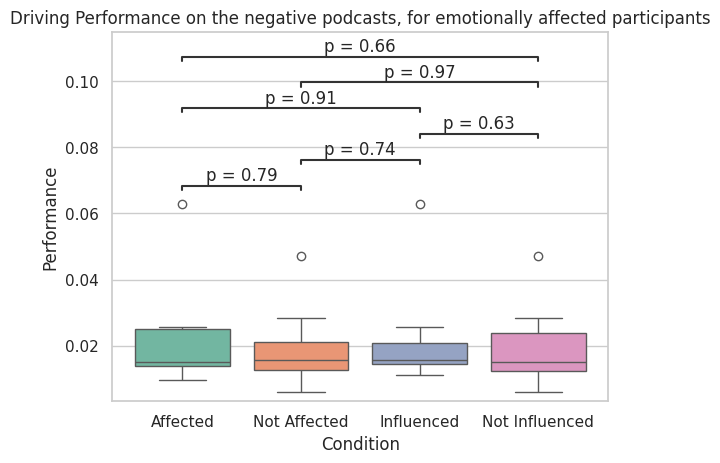

In [66]:
from itertools import combinations

negative_performance = pd.DataFrame({
  'Condition': ['Affected'] * len(negative_affected_performance) + ['Not Affected'] * len(negative_not_affected_performance) +
               ['Influenced'] * len(negative_influenced_performance) + ['Not Influenced'] * len(not_negative_influenced_performance),
  'Performance': negative_affected_performance + negative_not_affected_performance + negative_influenced_performance + not_negative_influenced_performance
})

#x = condition, y = performance
sns.boxplot(x='Condition', y='Performance', data=positive_performance, palette="Set2")
plt.title('Driving Performance on the negative podcasts, for emotionally affected participants')


#annotate the plot with statistical tests
conditions = [ 'Affected', 'Not Affected', 'Influenced', 'Not Influenced']

annotator = Annotator(plt.gca(),
                      pairs=list(combinations(conditions, 2)),
                      data=positive_performance,
                      x='Condition',
                      y='Performance')
annotator.configure(test='Mann-Whitney', text_format='simple', loc='inside', show_test_name=False)
annotator.apply_and_annotate()
plt.show()

{np.float64(0.0169990115394109), np.float64(0.04486630905646888), np.float64(0.016042644280665833), np.float64(0.01087607996681242), np.float64(0.008057978184714045), np.float64(0.015872769105952138), np.float64(0.010814431337062065), np.float64(0.01603427581379762), np.float64(0.03894674790734635), np.float64(0.011505662331797737), np.float64(0.03257780316039644), np.float64(0.01653472419368548), np.float64(0.010791915838571779)}
{np.float64(0.019109706076752858), np.float64(0.04727204609510413), np.float64(0.006000642451088233), np.float64(0.012225818447587038), np.float64(0.0156559423127656), np.float64(0.028453902073487598), np.float64(0.009472186533970587), np.float64(0.011209874162490235), np.float64(0.013156529906598607), np.float64(0.014903062671169856), np.float64(0.01614565286516726), np.float64(0.01269829247541348), np.float64(0.023984971916330138), np.float64(0.01466662334500072), np.float64(0.023305329630954965)}
Positive & Not Affected vs. Negative & Affected: Mann-Whitne

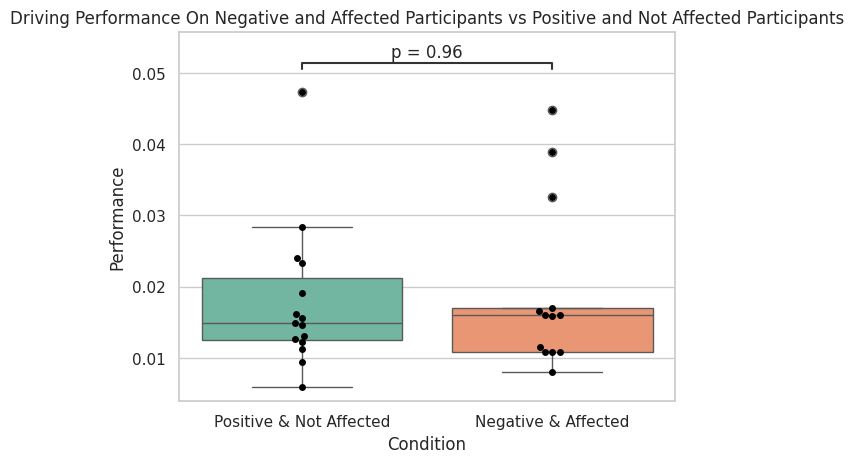

In [67]:
negative_influenced_and_affected = set(negative_influenced_performance + negative_affected_performance)
positive_not_influenced_and_not_affected = set(positive_not_affected_performance + not_positive_influenced_performance)

print(negative_influenced_and_affected)
print(positive_not_influenced_and_not_affected)

combined_perf = pd.DataFrame({
  'Condition':  ['Positive & Not Affected'] * len(positive_not_influenced_and_not_affected) + ['Negative & Affected'] * len(negative_influenced_and_affected),
  'Performance':  list(positive_not_influenced_and_not_affected) + list(negative_influenced_and_affected)
})

#x = condition, y = performance
sns.boxplot(x='Condition', y='Performance', data=combined_perf, palette="Set2")
plt.title('Driving Performance On Negative and Affected Participants vs Positive and Not Affected Participants')
sns.swarmplot(x='Condition', y='Performance', data=combined_perf, color='black')

#annotate the plot with statistical tests

annotator = Annotator(plt.gca(),
                      pairs=[('Negative & Affected', 'Positive & Not Affected')],
                      data=combined_perf,
                      x='Condition',
                      y='Performance')
annotator.configure(test='Mann-Whitney', text_format='simple', loc='inside', show_test_name=False)
annotator.apply_and_annotate()
plt.show()


Positive & Negatively Affected vs. Negative & Negatively Affected: Mann-Whitney-Wilcoxon test two-sided, P_val:7.583e-01 U_stat=9.100e+01


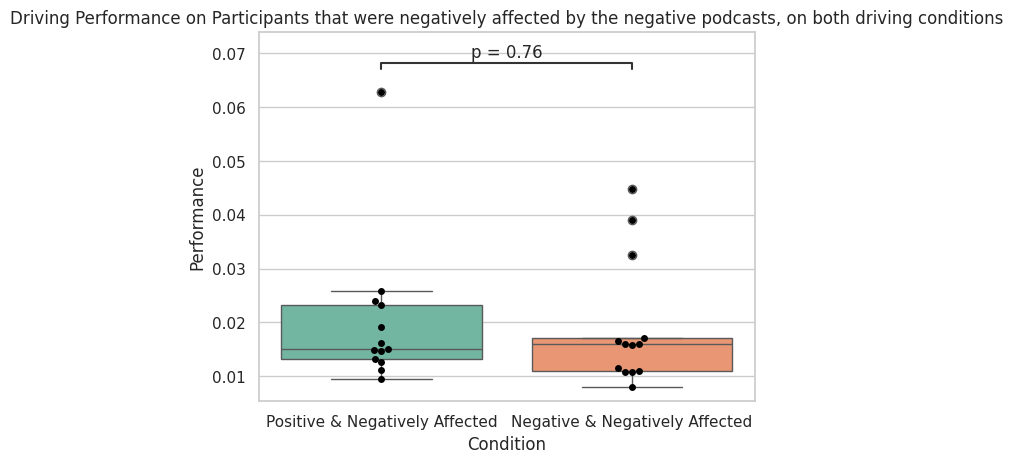

In [68]:
positive_perf_of_negatively_affected_people = [calm_stats[x * 4 + metric_index][stat_index] for x in negative_emotionally_affected]
positive_perf_of_negatively_influenced_people = [calm_stats[x * 4 + metric_index][stat_index] for x in negative_influenced]

positive_perf_negative_people = set(positive_perf_of_negatively_affected_people + positive_perf_of_negatively_influenced_people)


combined_perf = pd.DataFrame({
  'Condition':  ['Positive & Negatively Affected'] * len(positive_perf_negative_people) + ['Negative & Negatively Affected'] * len(negative_influenced_and_affected),
  'Performance':  list(positive_perf_negative_people) + list(negative_influenced_and_affected)
})

#x = condition, y = performance
sns.boxplot(x='Condition', y='Performance', data=combined_perf, palette="Set2")
plt.title('Driving Performance on Participants that were negatively affected by the negative podcasts, on both driving conditions')
sns.swarmplot(x='Condition', y='Performance', data=combined_perf, color='black')

#annotate the plot with statistical tests

annotator = Annotator(plt.gca(),
                      pairs=[('Negative & Negatively Affected', 'Positive & Negatively Affected')],
                      data=combined_perf,
                      x='Condition',
                      y='Performance')
annotator.configure(test='Mann-Whitney', text_format='simple', loc='inside', show_test_name=False)
annotator.apply_and_annotate()
plt.show()


Positive vs. Negative: Wilcoxon test (paired samples), P_val:1.000e+00 Stat=3.300e+01
Negative vs. Baseline: Wilcoxon test (paired samples), P_val:4.131e-01 Stat=2.300e+01
Baseline vs. Cool Down: Wilcoxon test (paired samples), P_val:3.223e-02 Stat=9.000e+00
Positive vs. Baseline: Wilcoxon test (paired samples), P_val:4.648e-01 Stat=2.400e+01
Negative vs. Cool Down: Wilcoxon test (paired samples), P_val:1.748e-01 Stat=1.700e+01
Positive vs. Cool Down: Wilcoxon test (paired samples), P_val:9.766e-03 Stat=5.000e+00


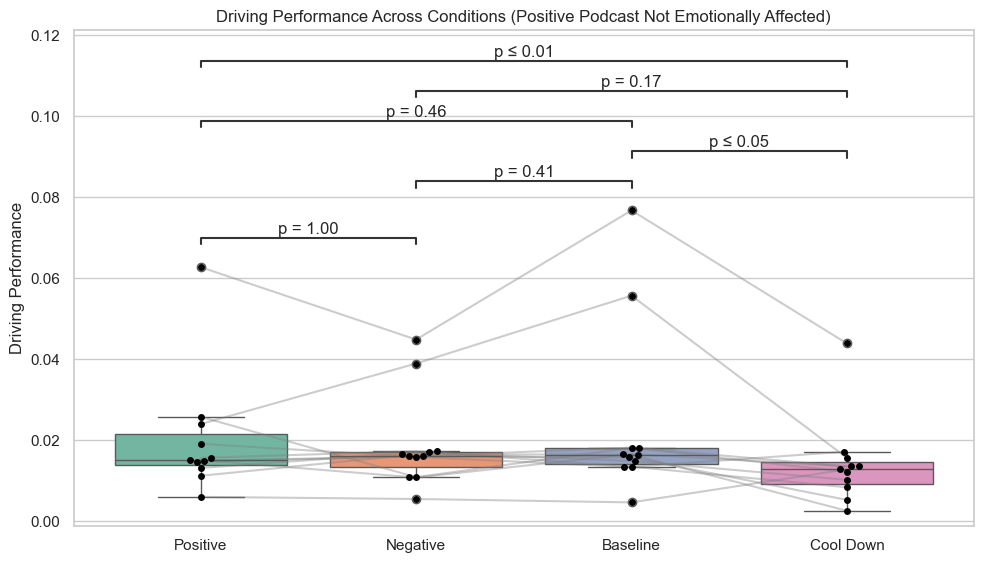

In [60]:
calm_filtered = [calm_stats[i] for i in range(len(calm_stats)) if i // 4 in negative_participant_indices]
intense_filtered = [intense_stats[i] for i in range(len(intense_stats)) if i // 4 in negative_participant_indices]
baseline_filtered = [baseline_stats[i] for i in range(len(baseline_stats)) if i // 4 in negative_participant_indices]
cool_down_filtered = [cool_down_stats[i] for i in range(len(cool_down_stats)) if i // 4 in negative_participant_indices]

paired_plot_all3(calm_filtered, intense_filtered, baseline_filtered, cool_down_filtered, 'Driving Performance Across Conditions (Positive Podcast Not Emotionally Affected)', 'Driving Performance', y='Mean', index=3)

[(np.float64(-0.03792148305751402), np.float64(0.7889330953150941), np.float64(-2.9557391278258605)), (np.float64(10.983112793738451), np.float64(11.761938060853389), np.float64(7171.737090184808)), (np.float64(2.3967514643704204), np.float64(1.603973145430685), np.float64(18.970882176616083)), (np.float64(0.023984971916330138), np.float64(0.04246425193658812), np.float64(-0.9346516798689588)), (np.float64(0.08960618430997049), np.float64(0.49251490669463477), np.float64(-1.420897542163454)), (np.float64(12.165313556123401), np.float64(13.592097717013353), np.float64(11099.01830963585)), (np.float64(1.7628087810351978), np.float64(0.865204339262749), np.float64(2.3757095955214913)), (np.float64(0.019109706076752858), np.float64(0.02575090064665459), np.float64(-0.9456724787799672)), (np.float64(0.0028019284599859664), np.float64(0.656521541735108), np.float64(-2.221255456714936)), (np.float64(9.365503685712845), np.float64(10.377023502706937), np.float64(4792.744724153255)), (np.float6

(<Axes: xlabel='Condition', ylabel='Mean'>,
 [<statannotations.Annotation.Annotation at 0x2026c6ac9b0>])

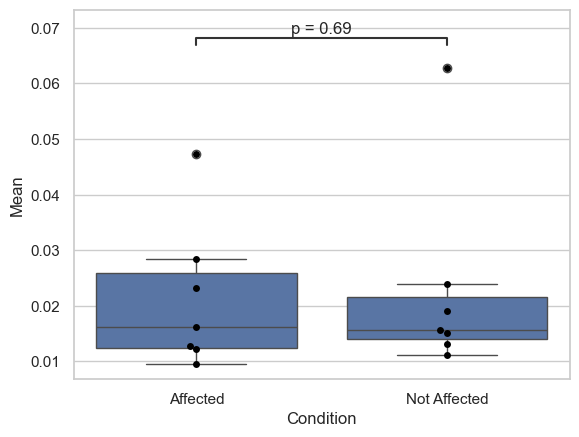

In [78]:
calm_filtered_pos = [calm_stats[i] for i in range(len(calm_stats)) if i // 4 in positive_participant_indices]
calm_filtered_neg = [calm_stats[i] for i in range(len(calm_stats)) if i // 4 in negative_participant_indices][:4*7]
print(calm_filtered_neg)
filter_data =pd.DataFrame({
    'Condition': ['Affected'] *( len(calm_filtered_pos) // 4) + ['Not Affected'] * (len(calm_filtered_neg) // 4),
    'Mean': [calm_filtered_pos[i][0] for i in range(len(calm_filtered_pos)) if i % 4 == 3] + [calm_filtered_neg[i][0] for i in range(len(calm_filtered_neg)) if i % 4 == 3],
})

sns.boxplot(x='Condition', y='Mean', data=filter_data)
sns.swarmplot(x='Condition', y='Mean', data=filter_data, color='black')
test_pairs = [('Affected', 'Not Affected')]
annotator = Annotator(plt.gca(), pairs=test_pairs, data=filter_data, x='Condition', y='Mean')
annotator.configure(test='Wilcoxon', text_format='simple', loc='inside', show_test_name=False)
annotator.apply_and_annotate()

In [15]:
pairs = [
        ('VelocityX', 'Lateral Velocity'),
        ('DistanceToTargetSpeed', 'Difference to Correct Speed'),
        ('DistanceToTargetPosition','Distance to Correct Lane'),
        ('DrivingPerformance', 'Driving Performance'),
        ]

titles = ['Lateral Velocity', 'Difference to Correct Speed', 'Distance to Correct Lane', 'Inverse Driving Performance']   
datasets = generate_datasets(calm_stats, intense_stats, pairs)
print_statistical_tests(datasets=datasets, titles=titles)
# datasets


T-test results for Lateral Velocity, intense vs calm:
Means: 0.2953621399995426
STDs: 0.08085808181541908
Mom^3s: 0.16529997928992363

Kruskal results for Lateral Velocity, intense vs calm:
Means: 0.3929708076289571
STDs: 0.7758376742179307
Mom^3s: 0.5906763307135396

Wilcoxn results for Lateral Velocity, intense vs calm:
Means: 0.34654998779296875
STDs: 0.11870574951171875
Mom^3s: 0.1083831787109375

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.5580117850007272
STDs: 0.9949485975214492
Mom^3s: 0.6629757833896248

Kruskal results for Difference to Correct Speed, intense vs calm:
Means: 0.7758376742179307
STDs: 0.7517095430780624
Mom^3s: 0.849441093557699

Wilcoxn results for Difference to Correct Speed, intense vs calm:
Means: 0.6396942138671875
STDs: 0.6094589233398438
Mom^3s: 0.83172607421875

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.804651725624311
STDs: 0.8780534458988539
Mom^3s: 0.9517903622384045

Kruskal results for Dis

In [ ]:
{'postive':[float(calm_stats[i][0]) for i in range(72) if i % 4 == 3], 
 'negative':[float(intense_stats[i][0]) for i in range(72) if i % 4 == 3]}

In [18]:
index = 1
std_calm_target_speed = [calm_stats[i][index] for i in range(len(calm_stats)) if i % 4 == 1]
std_calm_target_lane = [calm_stats[i][index] for i in range(len(calm_stats)) if i % 4 == 2]

std_intense_target_speed = [intense_stats[i][index] for i in range(len(intense_stats)) if i % 4 == 1]
std_intense_target_lane = [intense_stats[i][index] for i in range(len(intense_stats)) if i % 4 == 2]

std_baseline_target_speed = [baseline_stats[i][index] for i in range(len(baseline_stats)) if i % 4 == 1]
std_baseline_target_lane = [baseline_stats[i][index] for i in range(len(baseline_stats)) if i % 4 == 2]

std_cool_down_target_speed = [cool_down_stats[i][index] for i in range(len(cool_down_stats)) if i % 4 == 1]
std_cool_down_target_lane = [cool_down_stats[i][index] for i in range(len(cool_down_stats)) if i % 4 == 2]

std_calm_velocity_x = [calm_stats[i][index] for i in range(len(calm_stats)) if i % 4 == 0]
std_intense_velocity_x = [intense_stats[i][index] for i in range(len(intense_stats)) if i % 4 == 0]
std_baseline_velocity_x = [baseline_stats[i][index] for i in range(len(baseline_stats)) if i % 4 == 0]
std_cool_down_velocity_x = [cool_down_stats[i][index] for i in range(len(cool_down_stats)) if i % 4 == 0]

def normalize_speed(x):
   return (x) / 13

def noramlize_lane(x):
    return x / 90

max_vel = data['VelocityX'].max()
min_vel = data['VelocityX'].min()

def normalize_velocity(x):
    return (x - min_vel) / (max_vel - min_vel)


calm_perf = [normalize_speed(x) * noramlize_lane(y) * normalize_velocity(z) for x, y, z in zip(std_calm_target_speed, std_calm_target_lane, std_calm_velocity_x)]
intense_perf = [normalize_speed(x) * noramlize_lane(y) * normalize_velocity(z) for x, y, z in zip(std_intense_target_speed, std_intense_target_lane, std_intense_velocity_x)]
baseline_perf = [normalize_speed(x) * noramlize_lane(y) * normalize_velocity(z) for x, y, z in zip(std_baseline_target_speed, std_baseline_target_lane, std_baseline_velocity_x)]
cool_down_perf = [normalize_speed(x) * noramlize_lane(y) * normalize_velocity(z) for x, y, z in zip(std_cool_down_target_speed, std_cool_down_target_lane, std_cool_down_velocity_x)]

Positive vs. Negative: Wilcoxon test (paired samples), P_val:1.000e+00 Stat=8.500e+01
Negative vs. Baseline: Wilcoxon test (paired samples), P_val:1.000e+00 Stat=8.500e+01
Baseline vs. Cool Down: Wilcoxon test (paired samples), P_val:2.367e-02 Stat=3.400e+01
Positive vs. Baseline: Wilcoxon test (paired samples), P_val:4.683e-01 Stat=6.800e+01
Negative vs. Cool Down: Wilcoxon test (paired samples), P_val:1.203e-02 Stat=2.900e+01
Positive vs. Cool Down: Wilcoxon test (paired samples), P_val:5.386e-02 Stat=4.100e+01


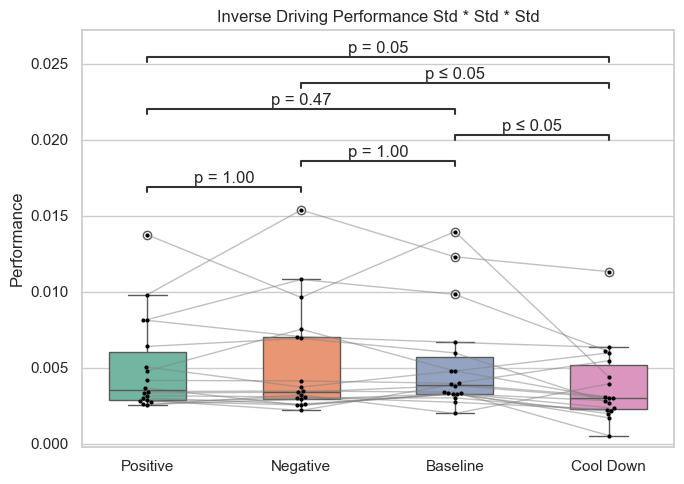

In [19]:
paired_data = pd.DataFrame({
    'Condition': ['Positive'] * len(calm_perf) + ['Negative'] * len(intense_perf) + ['Baseline'] * len(baseline_perf) + ['Cool Down'] * len(cool_down_perf),
    'Perf': calm_perf + intense_perf + baseline_perf + cool_down_perf,
})


plt.figure(figsize=(7, 5))
sns.boxplot(x='Condition', y='Perf', data=paired_data, palette="Set2", width=0.5)
sns.swarmplot(x='Condition', y='Perf', data=paired_data, color='black', size=3)

# print(paired_data['Mean'])
for i in range(len(calm_perf)):
    plt.plot(['Positive', 'Negative'], [calm_perf[i], intense_perf[i]], color='gray', alpha=0.5, linewidth=1)
    plt.plot(['Negative', 'Baseline'], [intense_perf[i], baseline_perf[i]], color='gray', alpha=0.5, linewidth=1)
    plt.plot(['Baseline', 'Cool Down'], [baseline_perf[i], cool_down_perf[i]], color='gray', alpha=0.5, linewidth=1)
plt.title('Inverse Driving Performance Std * Std * Std')
plt.ylabel('Performance')
plt.xlabel('')

test_pairs = [('Positive', 'Negative'), ('Negative', 'Baseline'), ('Positive', 'Baseline'), ('Negative', 'Cool Down'), ('Positive', 'Cool Down'), ('Baseline', 'Cool Down')]
annotator = Annotator(plt.gca(), pairs=test_pairs, data=paired_data, x='Condition', y='Perf')
annotator.configure(test='Wilcoxon', text_format='simple', loc='inside', show_test_name=False)
annotator.apply_and_annotate()

plt.tight_layout()
plt.xlabel('')

plt.savefig('perf_plots/combined_perf_boxplot.pdf', bbox_inches='tight')


In [21]:
#iqr outliers of intense_perf
q1 = np.percentile(intense_perf, 25)
q3 = np.percentile(intense_perf, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

#index of outliers
outliers = [i for i, x in enumerate(intense_perf) if x < lower_bound or x > upper_bound]
print(f'Outliers in intense_perf: {outliers}')

#recheck the outliers
participants = data.groupby('Participant')['DrivingPerformance'].mean().reset_index()
print(participants)
print(intense_perf)

Outliers in intense_perf: [0, 4, 10]
   Participant  DrivingPerformance
0     C1K4L9S8            0.035062
1     D0P7X9W6            0.013553
2     G2Y7J4Q1            0.015746
3     G9K4W1Z0            0.013851
4     I8L4N6G7            0.049078
5     J4X1T0D2            0.015167
6     J6W7Q4H5            0.009143
7     K4G7Y9O2            0.013269
8     L0S1Z2I3            0.013256
9     L1N3B5O2            0.024058
10    M0R6U5F9            0.074053
11    M4H6R2W9            0.015384
12    M7D3F5K4            0.097250
13    N7P5B8G0            0.006069
14    O4A0U8R1            0.014061
15    U6O5V2T9            0.033155
16    V9L0P2K7            0.018366
17    X5Q0G4J2            0.015208
[np.float64(0.030374106420018046), np.float64(0.009382418396655741), np.float64(0.017136127649003262), np.float64(0.011333582297911236), np.float64(0.03264900869947249), np.float64(0.009888968484699579), np.float64(0.00844423284760747), np.float64(0.011902856611040978), np.float64(0.01137181195013

Text(0.5, 1.0, 'Driving Performance STD*STD KDEs')

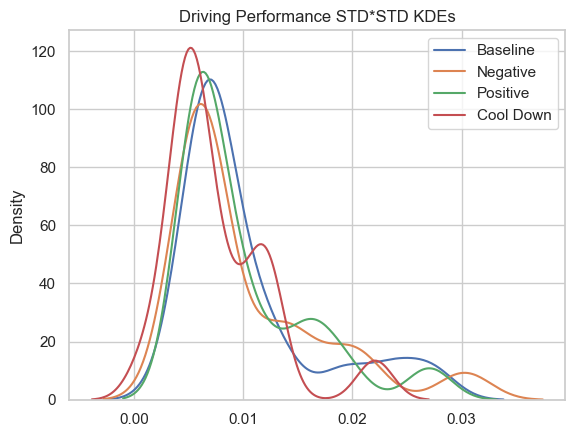

In [26]:
bw = 0.6
sns.kdeplot(baseline_perf, bw_adjust=bw)
sns.kdeplot(intense_perf, bw_adjust=bw)
sns.kdeplot(calm_perf,  bw_adjust=bw)
sns.kdeplot(cool_down_perf,  bw_adjust=bw)
plt.legend(['Baseline', 'Negative', 'Positive', 'Cool Down'])
plt.title('Driving Performance STD*STD KDEs')


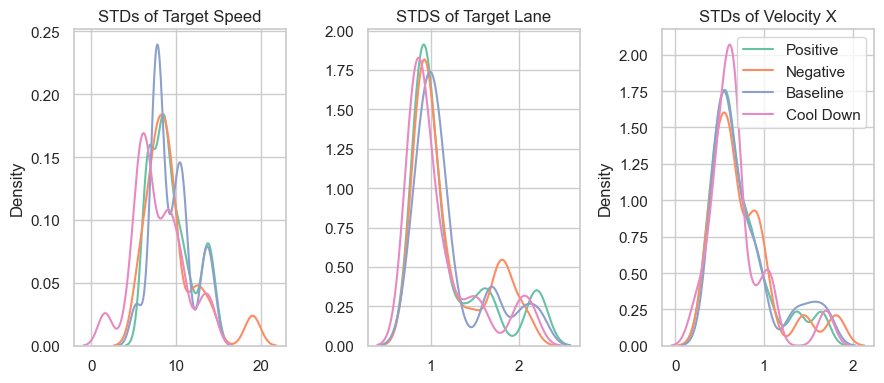

In [20]:
fix, ax = plt.subplots(1,3, figsize=(9, 4))
bandwidth = 0.5
sns.kdeplot(std_calm_target_speed, ax=ax[0], label='Positive', bw_adjust=bandwidth, color='#66c2a5')
sns.kdeplot(std_intense_target_speed, ax=ax[0], label='Negative', bw_adjust=bandwidth, color='#fc8d62')
sns.kdeplot(std_calm_target_lane, ax=ax[1], label='Positive',  bw_adjust=bandwidth, color='#66c2a5')
sns.kdeplot(std_intense_target_lane, ax=ax[1], label='Negative',  bw_adjust=bandwidth, color='#fc8d62')
sns.kdeplot(std_baseline_target_speed, ax=ax[0], label='Baseline',  bw_adjust=bandwidth, color='#8da0cb')
sns.kdeplot(std_baseline_target_lane, ax=ax[1], label='Baseline',  bw_adjust=bandwidth, color='#8da0cb')
sns.kdeplot(std_cool_down_target_speed, ax=ax[0], label='Cool Down',  bw_adjust=bandwidth, color='#e78ac3')
sns.kdeplot(std_cool_down_target_lane, ax=ax[1], label='Cool Down',  bw_adjust=bandwidth, color='#e78ac3')
sns.kdeplot(std_calm_velocity_x, ax=ax[2], label='Positive',  bw_adjust=bandwidth, color='#66c2a5')
sns.kdeplot(std_intense_velocity_x, ax=ax[2], label='Negative',  bw_adjust=bandwidth, color='#fc8d62')
sns.kdeplot(std_baseline_velocity_x, ax=ax[2], label='Baseline',  bw_adjust=bandwidth, color='#8da0cb')
sns.kdeplot(std_cool_down_velocity_x, ax=ax[2], label='Cool Down',  bw_adjust=bandwidth, color='#e78ac3')


plt.legend()
ax[1].set_ylabel('')
ax[0].set_title('STDs of Target Speed')
ax[1].set_title('STDS of Target Lane')
ax[2].set_title('STDs of Velocity X')
plt.tight_layout()



Text(0.5, 1.0, 'Participant Age vs overall Driving Performance Mean')

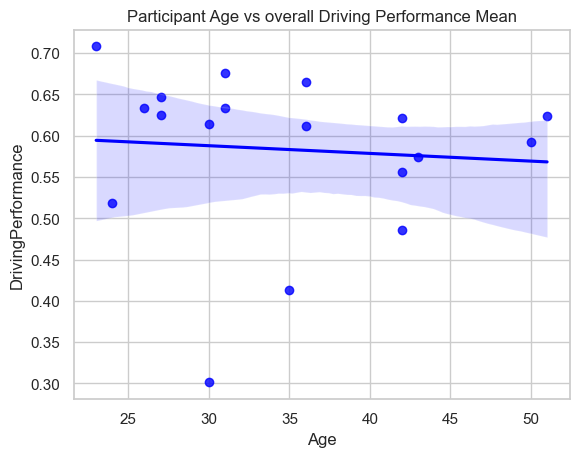

In [21]:
#plot regression line on participant age vs driving performance mean
age = data.groupby('Participant')['Age'].first().reset_index()
overall_perf = data.groupby('Participant')['DrivingPerformance'].mean().reset_index()
#cast age dtype to int
age['Age'] = age['Age'].astype(int)
overall_perf = pd.merge(overall_perf, age, on='Participant')
#regplot with color according to participant
sns.regplot(x='Age', y='DrivingPerformance', data=overall_perf, color='blue', marker='o')
plt.title('Participant Age vs overall Driving Performance Mean')

Text(0.5, 1.0, 'Participant Age vs Driving Performance Mean (Baseline)')

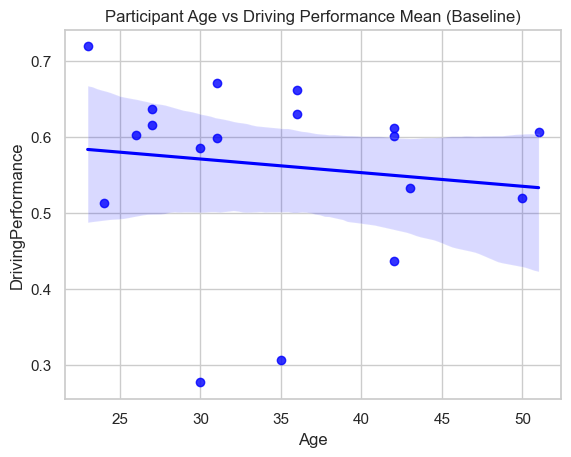

In [22]:
#plot regression line on participant age vs driving performance mean
age = data.groupby('Participant')['Age'].first().reset_index()
# overall_perf = data.groupby('Participant')['DrivingPerformance'].mean().reset_index()
#cast age dtype to int
age['Age'] = age['Age'].astype(int)
# overall_perf = pd.merge(overall_perf, age, on='Participant')
age['DrivingPerformance'] = baseline_driving_perf_means
#regplot with color according to participant
sns.regplot(x='Age', y='DrivingPerformance', data=age, color='blue', marker='o')
plt.title('Participant Age vs Driving Performance Mean (Baseline)')

In [41]:
wilcoxon(calm_perf, intense_perf).pvalue

np.float64(0.7660293579101562)

In [ ]:
pariticipant_performance = data.groupby('Participant')['DrivingPerformance'].mean().reset_index()
print(pariticipant_performance)
#calculate outliers based on interquartile range (IQR)
Q1 = pariticipant_performance['DrivingPerformance'].quantile(0.25)
Q3 = pariticipant_performance['DrivingPerformance'].quantile(0.75)
IQR = Q3 - Q1
# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter out the outliers
outliers = pariticipant_performance[(pariticipant_performance['DrivingPerformance'] <= lower_bound) | (pariticipant_performance['DrivingPerformance'] >= upper_bound)]




print(outliers)

   Participant  DrivingPerformance
0     C1K4L9S8            0.486298
1     D0P7X9W6            0.664998
2     G2Y7J4Q1            0.612080
3     G9K4W1Z0            0.614606
4     I8L4N6G7            0.412978
5     J4X1T0D2            0.625353
6     J6W7Q4H5            0.675477
7     K4G7Y9O2            0.632985
8     L0S1Z2I3            0.624387
9     L1N3B5O2            0.555666
10    M0R6U5F9            0.301208
11    M4H6R2W9            0.621679
12    M7D3F5K4            0.574676
13    N7P5B8G0            0.708068
14    O4A0U8R1            0.647322
15    U6O5V2T9            0.518500
16    V9L0P2K7            0.592207
17    X5Q0G4J2            0.633091
   Participant  DrivingPerformance
4     I8L4N6G7            0.412978
10    M0R6U5F9            0.301208


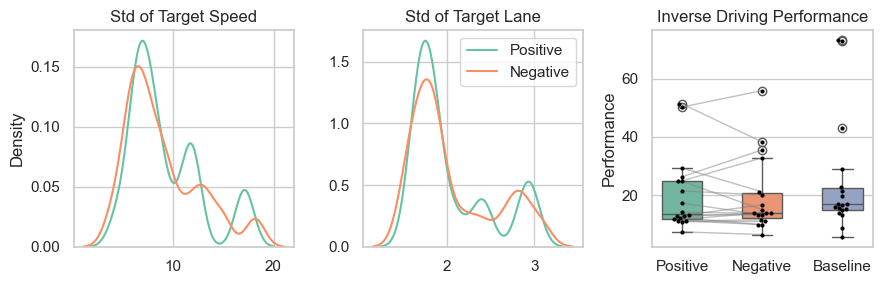

In [43]:
fix, ax = plt.subplots(1,3, figsize=(9, 3))
sns.kdeplot(std_calm_target_speed, ax=ax[0], label='Positive', bw_adjust=0.45, color='#66c2a5')
sns.kdeplot(std_intense_target_speed, ax=ax[0], label='Negative', bw_adjust=0.45, color='#fc8d62')
sns.kdeplot(std_calm_target_lane, ax=ax[1], label='Positive',  bw_adjust=0.45, color='#66c2a5')
sns.kdeplot(std_intense_target_lane, ax=ax[1], label='Negative',  bw_adjust=0.45, color='#fc8d62')
ax[1].legend()
ax[1].set_ylabel('')
ax[0].set_title('Std of Target Speed')
ax[1].set_title('Std of Target Lane')



sns.boxplot(x='Condition', y='Perf', data=paired_data, palette="Set2", width=0.5, ax=ax[2])
sns.swarmplot(x='Condition', y='Perf', data=paired_data, color='black', size=3, ax=ax[2])

# print(paired_data['Mean'])
for i in range(len(calm_perf)):
    ax[2].plot(['Positive', 'Negative'], [calm_perf[i], intense_perf[i]], color='gray', alpha=0.5, linewidth=1)
plt.title('Inverse Driving Performance')
plt.ylabel('Performance')
plt.xlabel('')
plt.tight_layout()
plt.savefig('perf_plots/combined_perf_boxplot.pdf', bbox_inches='tight')

<Axes: ylabel='Density'>

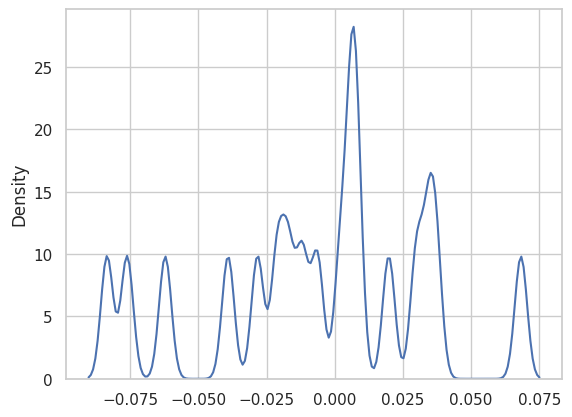

In [48]:
data_diff =  [intense_stats[i][0] - calm_stats[i][0] for i in range(len(intense_stats)) if i % 4 == 3]
sns.kdeplot(data_diff, bw_adjust=0.1)

In [ ]:
%matplotlib agg

intense_stats_wo, calm_stats_wo, data_wo = get_all_stats(remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'], save_folder='perf_plots/wo/')
dataset_wo = generate_datasets(calm_stats=calm_stats_wo, intense_stats=intense_stats_wo, pairs=pairs)

%matplotlib inline

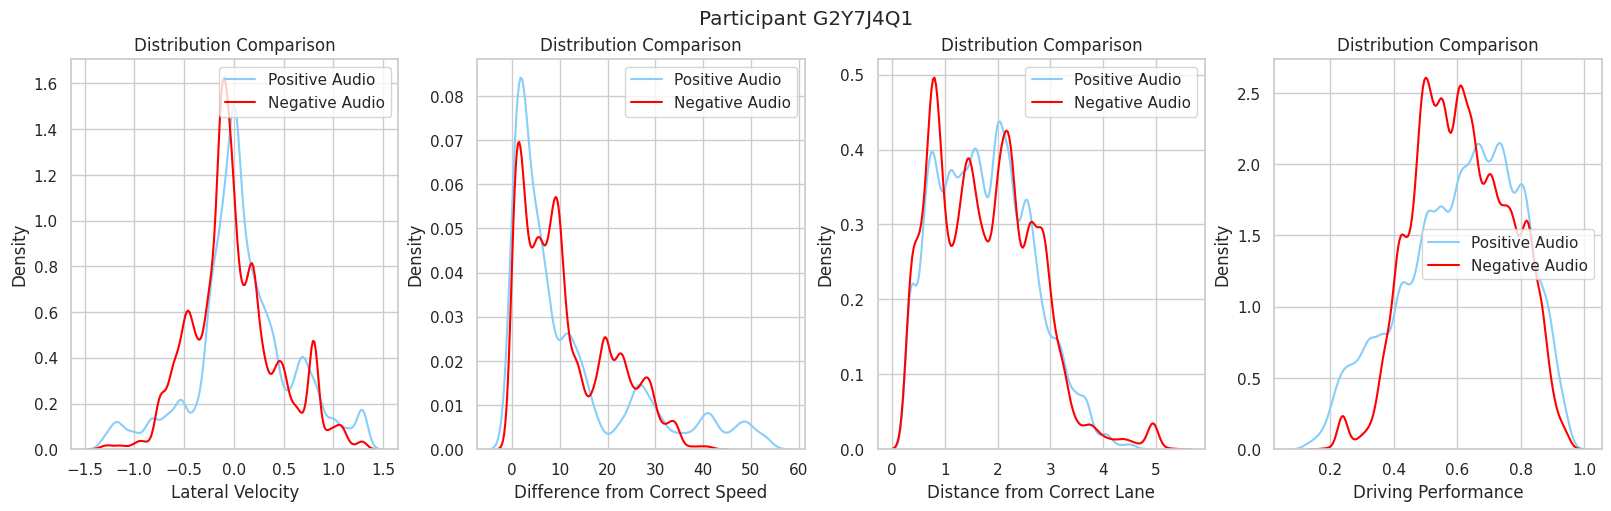

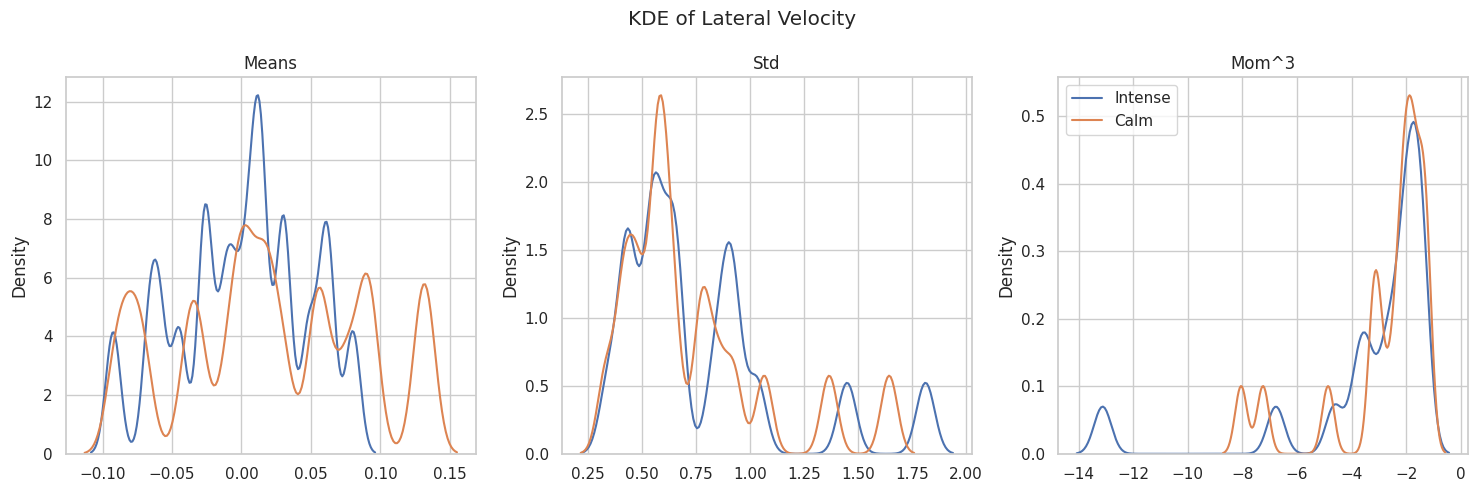

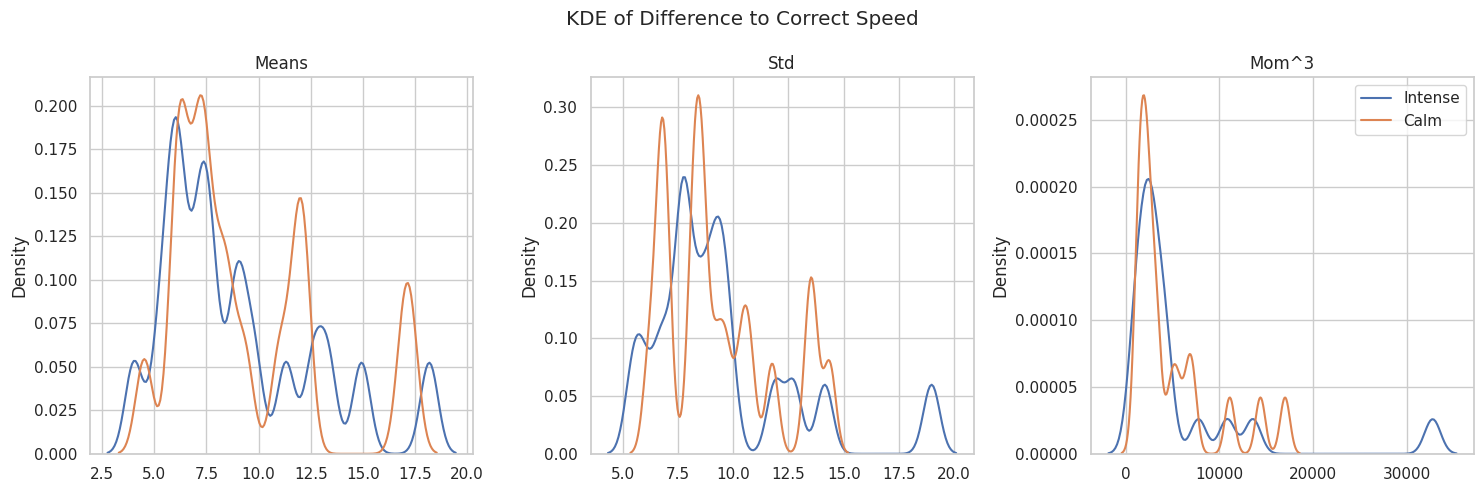

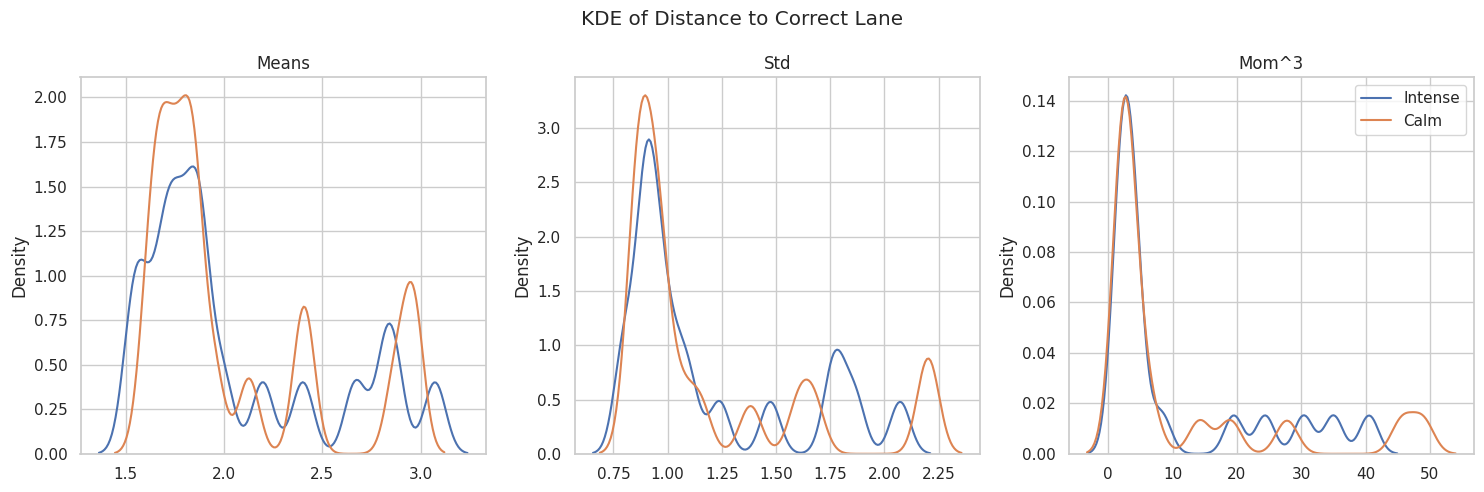

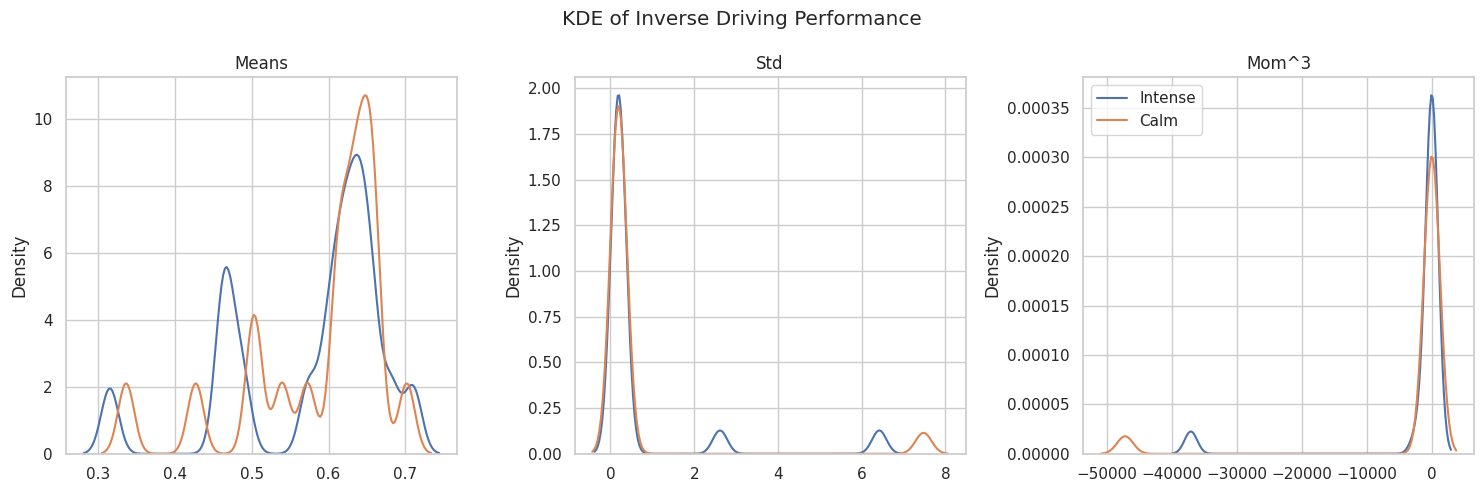

In [52]:
pairs = [
        ('VelocityX', 'Lateral Velocity'),
        ('DistanceToTargetSpeed', 'Difference to Correct Speed'),
        ('DistanceToTargetPosition','Distance to Correct Lane'),
        ('DrivingPerformance', 'Driving Performance'),
        ]

datasets = generate_datasets(calm_stats=calm_stats, intense_stats=intense_stats, pairs=pairs)
titles = ['Lateral Velocity', 'Difference to Correct Speed', 'Distance to Correct Lane', 'Inverse Driving Performance']   

def plot_all_perf_param_kdes(datasets=datasets, titles=titles):
    for j, (intense, calm) in enumerate(datasets):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i in range(3):
            sns.kdeplot([x[i] for x in intense], label=f'Intense', ax=axes[i], bw_adjust=0.2)
            sns.kdeplot([x[i] for x in calm], label=f'Calm', ax=axes[i], bw_adjust=0.2)
            axes[i].set_title(f'{['Means', 'Std', 'Mom^3'][i]}')
        plt.suptitle(f'KDE of {titles[j]}')
        plt.tight_layout()
        plt.savefig('kde_lateral_velocity_statistics.png', dpi=300)
        plt.legend()
        plt.show()

plot_all_perf_param_kdes(datasets=datasets, titles=titles)

In [ ]:

def plot_all_boxplot_perf(datasets=datasets, titles=titles):
    for j, (intense, calm) in enumerate(datasets):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i in range(3):
            sns.boxplot({'Negative':[x[i] for x in intense], 'Positive':[x[i] for x in calm]}, ax=axes[i],palette={'Negative':'tomato', 'Positive':'skyblue'} )
            sns.swarmplot({'Negative':[x[i] for x in intense], 'Positive':[x[i] for x in calm]}, ax=axes[i], color='black', alpha=0.5)
            axes[i].set_title(f'{['Means', 'Std', 'Mom^3'][i]}')
        plt.suptitle(f'Boxplot of {titles[j]}')
        plt.tight_layout()
        plt.savefig('boxplot.png', dpi=300)
        # plt.legend()
        plt.show()

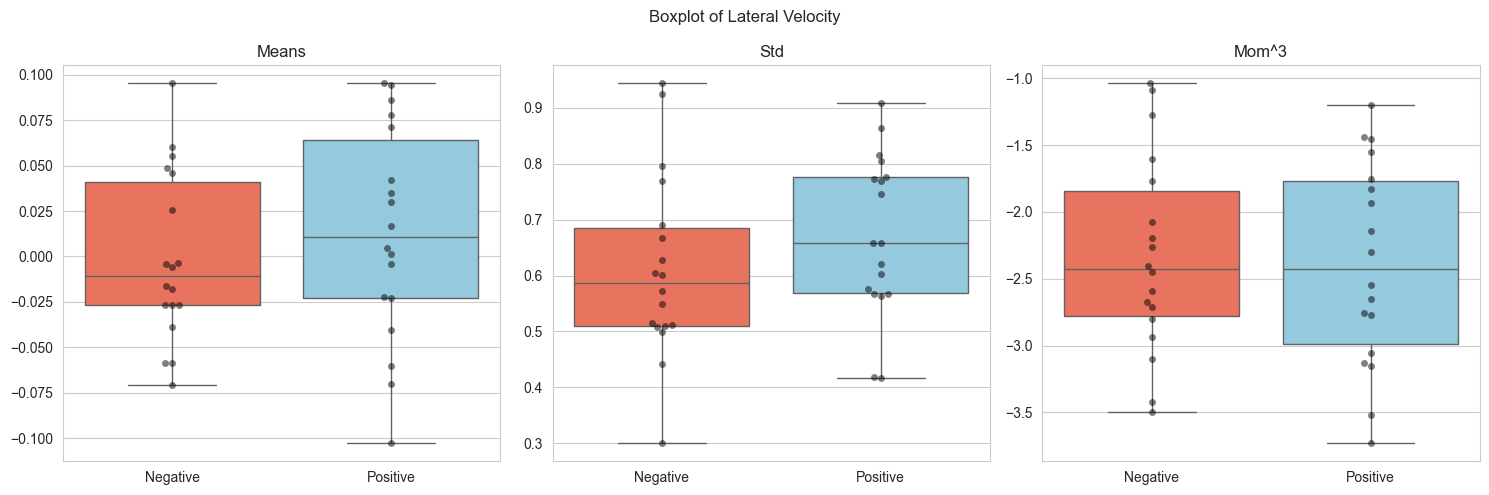

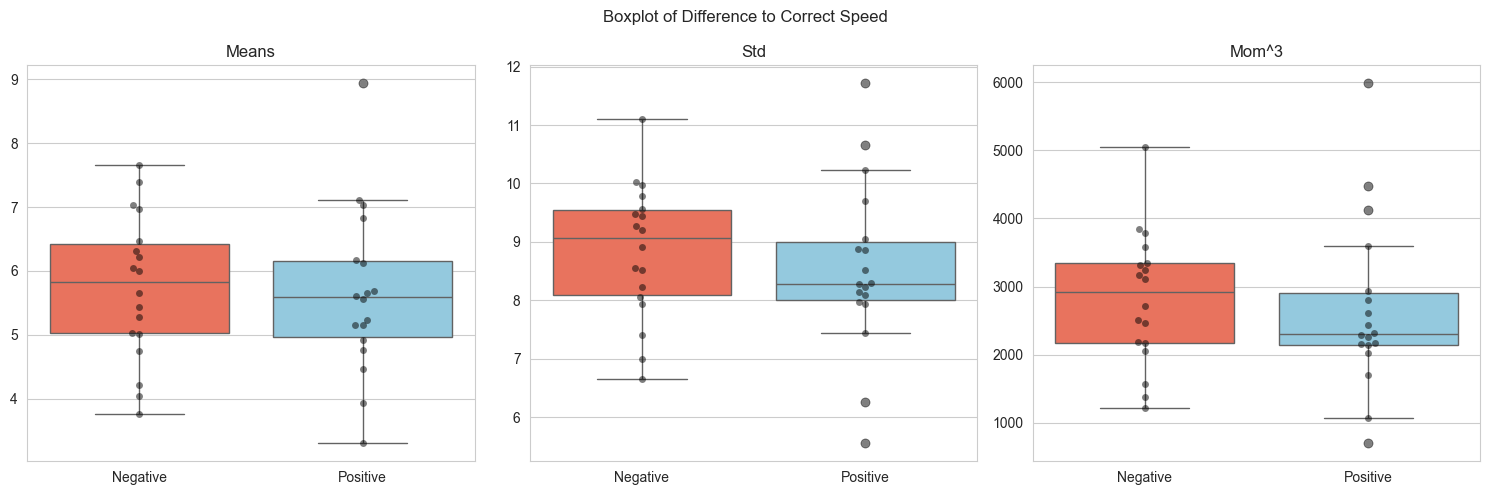

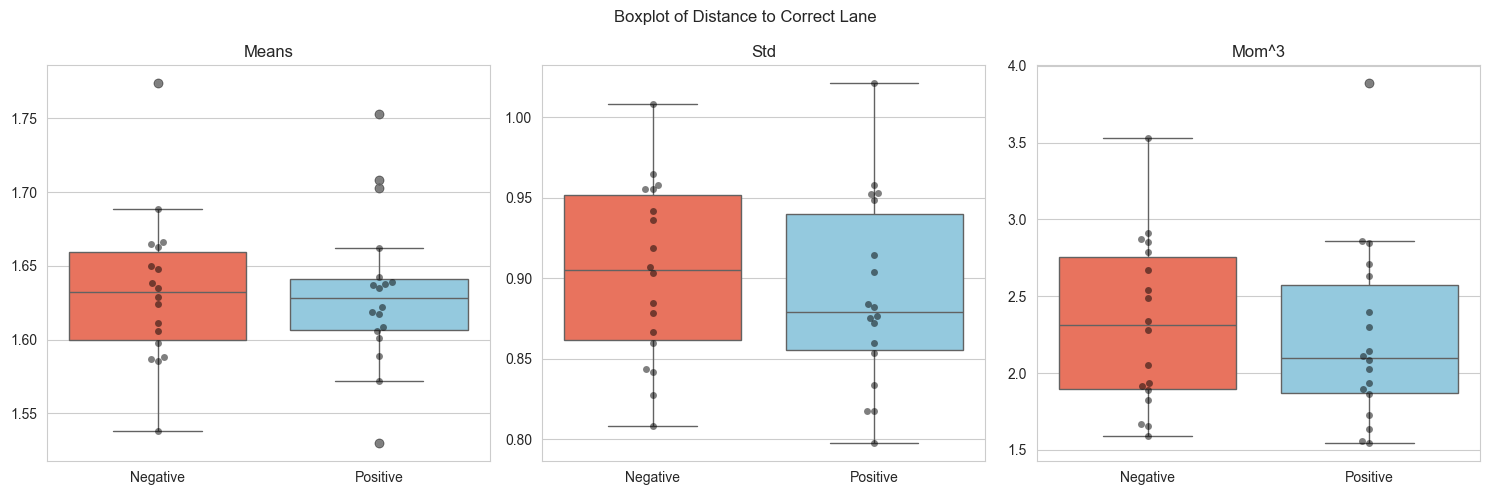

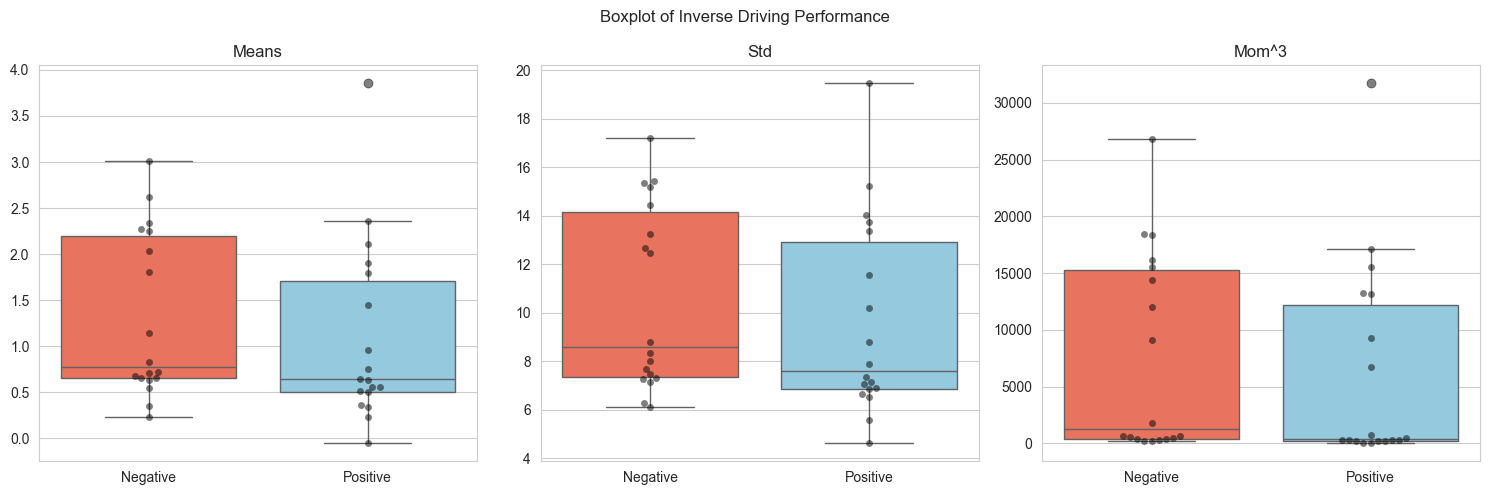

In [ ]:
plot_all_boxplot_perf(datasets=datasets, titles=titles)

In [ ]:
%matplotlib agg

intense_stats_wo, calm_stats_wo = get_all_stats(remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'], save_folder='perf_plots/wo_events/')
dataset_wo = generate_datasets(calm_stats=calm_stats_wo, intense_stats=intense_stats_wo, pairs=pairs)

%matplotlib inline

['C1K4L9S8', 'D0P7X9W6', 'G2Y7J4Q1', 'G9K4W1Z0', 'I8L4N6G7', 'J4X1T0D2', 'J6W7Q4H5', 'K4G7Y9O2', 'L0S1Z2I3', 'L1N3B5O2', 'M0R6U5F9', 'M4H6R2W9', 'M7D3F5K4', 'N7P5B8G0', 'O4A0U8R1', 'U6O5V2T9', 'V9L0P2K7', 'X5Q0G4J2', 'Z6A2W1E8']
C1K4L9S8 OK
D0P7X9W6 OK
G2Y7J4Q1 OK
G9K4W1Z0 OK
I8L4N6G7 OK
J4X1T0D2 OK
J6W7Q4H5 OK
K4G7Y9O2 OK
L0S1Z2I3 OK
L1N3B5O2 OK
M0R6U5F9 OK
M4H6R2W9 OK
M7D3F5K4 OK
N7P5B8G0 OK
O4A0U8R1 OK
U6O5V2T9 OK
V9L0P2K7 OK
X5Q0G4J2 OK
Z6A2W1E8 OK


In [ ]:
# plot_all_perf_param_kdes(datasets=dataset_wo, titles=titles)

In [ ]:
print(len([x for x,_,_ in dataset_wo[0][1] if x not in [None, np.nan, 'NaN', 'nan']]))
for j, (intense, calm) in enumerate(dataset_wo):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')

NameError: name 'dataset_wo' is not defined

In [ ]:
# plot_all_boxplot_perf(datasets=dataset_wo, titles=titles)

In [ ]:
speed_intense = datasets[1][0]
speed_calm = datasets[1][1]

### Analyze Gender Dependencies

##### Male only

In [ ]:
%matplotlib agg

calm_man, intense_man = get_all_stats(drop_gender='FEMALE', save_folder='perf_plots/men/')
dataset_man = generate_datasets(calm_stats=calm_man, intense_stats=intense_man, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_man, titles=titles)

%matplotlib inline

In [ ]:
for j, (intense, calm) in enumerate(dataset_man):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.8966255274417589
STDs: 0.6411000442012771
Mom^3s: 0.8041302498488301

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.09976690547282356
STDs: 0.13323077305975203
Mom^3s: 0.18185019002910094

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.5237563333502224
STDs: 0.33810260571861295
Mom^3s: 0.33880064390495923

T-test results for Car Speed, intense vs calm:
Means: 0.09976690547282356
STDs: 0.13323077305975203
Mom^3s: 0.18185019002910094


##### With outliers removed

In [ ]:
%matplotlib agg
calm_man_outl, intense_man_outl = get_all_stats(drop_gender='FEMALE',remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'], save_folder='perf_plots/men_outl/')
dataset_man_outl = generate_datasets(calm_stats=calm_man_outl, intense_stats=intense_man_outl, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_man_outl, titles=titles)
%matplotlib inline

In [ ]:
for j, (intense, calm) in enumerate(dataset_man_outl):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.21455779259860913
STDs: 0.9025188083563968
Mom^3s: 0.21621606147147773

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.09976690547282356
STDs: 0.13323077305975203
Mom^3s: 0.18185019002910094

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.8597781195951577
STDs: 0.8554482696474912
Mom^3s: 0.6685909656924475

T-test results for Car Speed, intense vs calm:
Means: 0.09976690547282356
STDs: 0.13323077305975203
Mom^3s: 0.18185019002910094


##### Female only

In [ ]:
%matplotlib agg
calm_man, intense_man = get_all_stats(drop_gender='MALE', save_folder='perf_plots/women/')
dataset_man = generate_datasets(calm_stats=calm_man, intense_stats=intense_man, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_man, titles=titles)
%matplotlib inline

In [ ]:
for j, (intense, calm) in enumerate(dataset_man_outl):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.21455779259860913
STDs: 0.9025188083563968
Mom^3s: 0.21621606147147773

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.09976690547282356
STDs: 0.13323077305975203
Mom^3s: 0.18185019002910094

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.8597781195951577
STDs: 0.8554482696474912
Mom^3s: 0.6685909656924475

T-test results for Car Speed, intense vs calm:
Means: 0.09976690547282356
STDs: 0.13323077305975203
Mom^3s: 0.18185019002910094


##### With outliers removed

In [ ]:
%matplotlib agg
calm_man_outl, intense_man_outl = get_all_stats(drop_gender='MALE',remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'], save_folder='perf_plots/women_outl/')
dataset_man_outl = generate_datasets(calm_stats=calm_man_outl, intense_stats=intense_man_outl, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_man_outl, titles=titles)
%matplotlib inline

In [ ]:
for j, (intense, calm) in enumerate(dataset_man_outl):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.257723898374721
STDs: 0.4108794815425716
Mom^3s: 0.5511735750053153

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.4801060800460869
STDs: 0.8806314528291882
Mom^3s: 0.571620772560518

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.8640353113177037
STDs: 0.6377910003602814
Mom^3s: 0.3909064506267478

T-test results for Car Speed, intense vs calm:
Means: 0.4801060800460869
STDs: 0.8806314528291882
Mom^3s: 0.571620772560518


### Analyzing ordering effect

#### PN 

In [ ]:
%matplotlib agg

calm_pn, intense_pn = get_all_stats(drop_order='NP', remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'], save_folder='perf_plots/PN/')
dataset_pn = generate_datasets(calm_stats=calm_pn, intense_stats=intense_pn, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_pn, titles=titles)

%matplotlib inline

In [ ]:
from scipy.stats import kruskal
for j, (intense, calm) in enumerate(dataset_pn):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')
    print(f'\nKruskal results for {titles[j]}, intense vs calm:')
    print(f'Means: {kruskal([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {kruskal([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {kruskal([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.15226117407634776
STDs: 0.11007925873311876
Mom^3s: 0.3714016998386561

Kruskal results for Lateral Velocity, intense vs calm:
Means: 0.22647606604348455
STDs: 0.7623688184698474
Mom^3s: 1.0

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.6890271361382726
STDs: 0.5530033330860247
Mom^3s: 0.6122161211799042

Kruskal results for Difference to Correct Speed, intense vs calm:
Means: 0.8205958397554376
STDs: 0.36434612663355204
Mom^3s: 0.8798291600118151

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.046155774177329995
STDs: 0.045667990277228517
Mom^3s: 0.08942129158753905

Kruskal results for Distance to Correct Lane, intense vs calm:
Means: 0.5967012167293555
STDs: 0.5967012167293555
Mom^3s: 0.6501474440948595

T-test results for Car Speed, intense vs calm:
Means: 0.6890271361382726
STDs: 0.5530033330860247
Mom^3s: 0.6122161211799042

Kruskal results for Car Speed, intense v

#### NP

In [ ]:
%matplotlib agg
calm_np, intense_np = get_all_stats(drop_order='PN', remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'], save_folder='perf_plots/NP/')
dataset_np = generate_datasets(calm_stats=calm_np, intense_stats=intense_np, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_np, titles=titles)

%matplotlib inline

In [ ]:
from scipy.stats import kruskal
for j, (intense, calm) in enumerate(dataset_np):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')
    print(f'\nKruskal results for {titles[j]}, intense vs calm:')
    print(f'Means: {kruskal([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {kruskal([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {kruskal([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.3556519914590071
STDs: 0.36067970444815245
Mom^3s: 0.12628805976909227

Kruskal results for Lateral Velocity, intense vs calm:
Means: 0.3538369006847303
STDs: 0.6911022238448452
Mom^3s: 0.5659921481957904

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.644533146825903
STDs: 0.3636708903682214
Mom^3s: 0.8302095343675412

Kruskal results for Difference to Correct Speed, intense vs calm:
Means: 0.9647839776414967
STDs: 0.4015419876158456
Mom^3s: 0.9647839776414967

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.20118904874593646
STDs: 0.20083928279739688
Mom^3s: 0.23715261185316996

Kruskal results for Distance to Correct Lane, intense vs calm:
Means: 0.8946258095467479
STDs: 0.8252828980151854
Mom^3s: 0.8252828980151854

T-test results for Car Speed, intense vs calm:
Means: 0.644533146825903
STDs: 0.3636708903682214
Mom^3s: 0.8302095343675412

Kruskal results for Car Speed, 